In [1]:
import sys
sys.path.append('..')

In [2]:
from elasticsearch import Elasticsearch
es = Elasticsearch()
from lib.classification.elastic import search_item, build_synonyms_graph, analyze_digraph
from lib.obo import read_ontology, Ontology
from geo_annotation.import_ontology_es import import_ontology
import networkx as nx
import pandas as pd
pd.set_option('display.width', 512)

In [3]:
from importlib import reload
import lib.classification.elastic
reload(lib.classification.elastic)

<module 'lib.classification.elastic' from '../lib/classification/elastic.py'>

In [37]:
ontology = read_ontology('../data/geo-annotation/doid-patched.obo',
                         exclude_duplicates=True)

Read obo graph
Name: 
Type: DiGraph
Number of nodes: 6593
Number of edges: 6591
Average in degree:   0.9997
Average out degree:   0.9997


In [38]:
# Убираем синонимы состоящие только из коротких слов  (len <= 2 )
# (вообще ошибка происходит изза стоп-слов в Elasticsearch, но так проще)

def cell():
    import re
    def tokenize(s):
        return re.split(r'[^\w\d]+', s)
    
    def all_short(synonym):
        return all(len(t) <= 2 for t in tokenize(synonym))
    
    for item_id, item in ontology.meta.items():
        item.synonyms = [s for s in item.synonyms if not all_short(s)]

cell()

In [39]:
import_ontology(ontology, 'disease_ontology')

(6592, [])

In [44]:
syn_ontology = Ontology(build_synonyms_graph(ontology, es, 'disease_ontology'), list(ontology.items()))

In [45]:
print(nx.info(syn_ontology.graph))

Name: 
Type: DiGraph
Number of nodes: 5259
Number of edges: 7083
Average in degree:   1.3468
Average out degree:   1.3468


In [46]:
bad_components = list(x for x in nx.strongly_connected_components(syn_ontology.graph) if len(x) > 1)
bad_components

[]

In [29]:
index = 0

In [35]:
def cell():
    global index
    comp = bad_components[index]
    print('components #{}: {}'.format(index, comp))
    print()
    for node in comp:
        print(node)
        print('\n'.join(syn_ontology.meta[node].names()))
        print()
    index += 1
        
cell()

components #3: {'DOID:3627', 'DOID:7693'}

DOID:3627
aortic aneurysm
abdominal aortic aneurysm, ruptured
aortic aneurysm of unspecified site, ruptured
aortic aneurysm of unspecified site, ruptured (disorder)
ruptured abdominal aortic aneurysm (disorder)
ruptured aortic aneurysm (disorder)
ruptured aortic aneurysm nos
ruptured aortic aneurysm nos (disorder)
ruptured thoracic aneurysm
ruptured thoracic aortic aneurysm
ruptured thoracic aortic aneurysm (disorder)
ruptured thoracoabdominal aortic aneurysm
thoracic aortic aneurysm which has ruptured (disorder)
thoracic aortic aneurysm, ruptured
thoracoabdominal aortic aneurysm, ruptured (disorder)

DOID:7693
abdominal aortic aneurysm
aortic aneurysm, familial abdominal 1



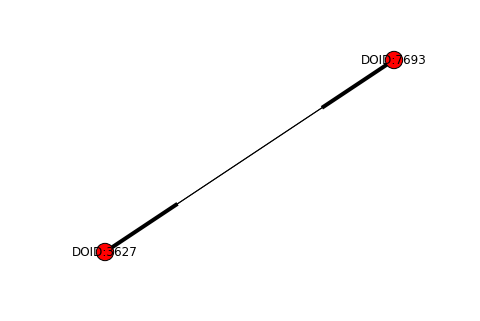

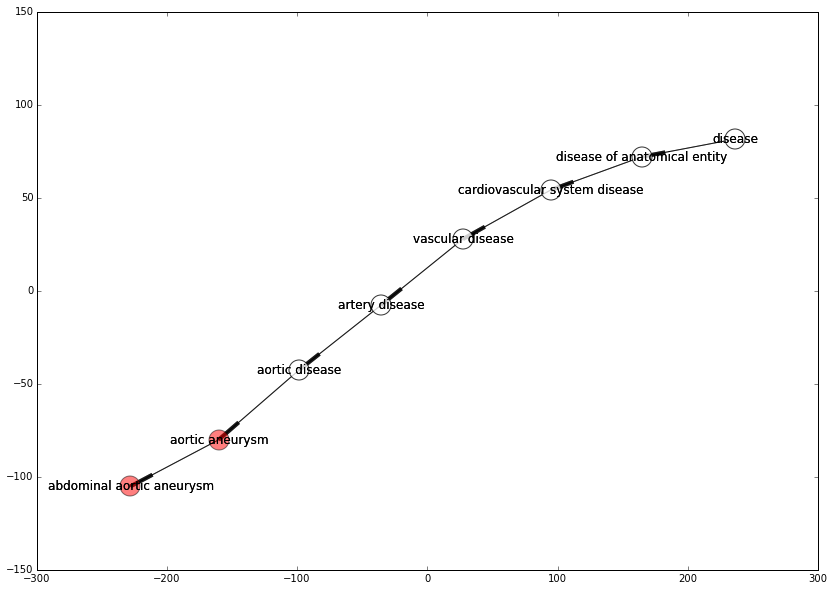

In [36]:
%matplotlib inline
nx.draw(nx.subgraph(syn_ontology.graph, bad_components[index-1]), with_labels=True)
matches_graph(ontology, bad_components[index-1])

In [15]:
from lib.utils import map_series, expand_dataframe, expand, flatten

def sub_ontology(nodes, ontology):
    subset = set(flatten([nx.shortest_path(ontology.graph, 'DOID:4', cls) for cls in nodes]))
    for n in nodes:
        subset.add(n)
    return nx.subgraph(ontology.graph, subset)
def matches_graph(ontology, matches, vd_classes=None, figsize=None, prog='neato'):
    names_dict = dict([(item.id, item.name) for item in ontology.items()])
    matches = [m for m in matches if m in ontology.graph.nodes()]
    vd_classes = vd_classes or []
    import matplotlib.pyplot as plt
    figsize = figsize or (14, 10)
    plt.figure(figsize=figsize) 
    import networkx as nx
    
    G = sub_ontology(list(matches) + vd_classes, ontology)
    pos=nx.pygraphviz_layout(G, prog=prog) 
    
    labels = dict((k, v) for (k, v) in names_dict.items() if k in G.nodes())
    nodes_other = [x for x in G.nodes() if x not in matches]
    
    nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='r',
             alpha=0.5,
            nodelist=matches)
    
    nx.draw_networkx(G, labels=labels, 
        pos=pos, 
        node_size=400,
        node_color='w',
         alpha=0.8,
        nodelist=nodes_other)
    
    if vd_classes:
        nx.draw_networkx(G, labels=labels, 
            pos=pos, 
            node_size=400,
            node_color='g',
            alpha=0.5,
#             font_color='g',                     
            nodelist=vd_classes)
        
    plt.show()

In [ ]:
def cell():
    q = errors[0:2]
    d1 = q[0]
    d2 = q[1]
    def patch(d):
        d = d.copy()
        columns = ['first', 'second']
        name = ', '.join(d.columns)
        d.index = pd.MultiIndex.from_tuples([(name, n) for n in range(d.shape[0])])
        d.columns = columns
        return d
    return pd.concat([patch(d) for d in errors])    
import qgrid

qgrid.show_grid(cell())


In [ ]:
for e in errors:
    print(e)
    print()